In [ ]:
# === RATRAG: CHAIN-OF-THOUGHT WITH EVIDENCE INTEGRATION ===
# This notebook implements RatRAG - a sophisticated approach that combines:
# 1. Chain-of-Thought (CoT) reasoning for complex question decomposition
# 2. Step-by-step evidence retrieval for each reasoning step
# 3. Iterative revision of reasoning based on retrieved evidence
# 4. Final synthesis incorporating all evidence-grounded reasoning steps

from dotenv import load_dotenv
import os

# Load environment variables for API access
load_dotenv()

# Verify OpenAI API key is available for LLM operations
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file")

print("RatRAG environment configured successfully")
print("This approach performs evidence-backed reasoning for each thought step")

In [ ]:
# === KNOWLEDGE BASE SETUP FOR RATRAG ===
# Configure the retrieval system that will provide evidence for each reasoning step
# RatRAG requires high-quality retrieval since each CoT step depends on accurate evidence

def get_retriever():
    """
    Create a FAISS-based retriever for UCSC knowledge base
    
    RatRAG uses this retriever to find supporting evidence for each
    step in the chain-of-thought reasoning process
    """
    import pandas as pd
    from langchain.document_loaders import DataFrameLoader  
    from langchain.text_splitter import CharacterTextSplitter
    from langchain.embeddings import HuggingFaceEmbeddings
    from langchain.vectorstores import FAISS

    print("Loading UCSC knowledge base for evidence retrieval...")
    
    # Load UCSC passages that will serve as evidence sources
    ucsc_passage_df = pd.read_csv("passage.csv")
    ucsc_passage_data_loader = DataFrameLoader(ucsc_passage_df, page_content_column="passage")
    ucsc_passage_data = ucsc_passage_data_loader.load()
 
    # Create smaller chunks for precise evidence retrieval
    # Smaller chunks (200 chars) ensure focused evidence for each reasoning step
    text_splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=50)
    docs = text_splitter.split_documents(ucsc_passage_data)
    
    # Create embeddings and vector store for semantic search
    embeddings = HuggingFaceEmbeddings()
    db = FAISS.from_documents(docs, embeddings)
    
    print(f"Vector store created with {len(docs)} document chunks")
    return db.as_retriever()

# Initialize the retriever for evidence collection
retriever = get_retriever()
print("Retriever ready for step-by-step evidence gathering")

Created a chunk of size 265, which is longer than the specified 200
Created a chunk of size 1411, which is longer than the specified 200
Created a chunk of size 294, which is longer than the specified 200
Created a chunk of size 395, which is longer than the specified 200
Created a chunk of size 298, which is longer than the specified 200
Created a chunk of size 324, which is longer than the specified 200
Created a chunk of size 470, which is longer than the specified 200
Created a chunk of size 662, which is longer than the specified 200
Created a chunk of size 451, which is longer than the specified 200
Created a chunk of size 245, which is longer than the specified 200
Created a chunk of size 226, which is longer than the specified 200
Created a chunk of size 580, which is longer than the specified 200
Created a chunk of size 1970, which is longer than the specified 200
Created a chunk of size 617, which is longer than the specified 200
Created a chunk of size 312, which is longer t

Created a chunk of size 205, which is longer than the specified 200
Created a chunk of size 950, which is longer than the specified 200
Created a chunk of size 622, which is longer than the specified 200
Created a chunk of size 632, which is longer than the specified 200
Created a chunk of size 215, which is longer than the specified 200
Created a chunk of size 394, which is longer than the specified 200
Created a chunk of size 254, which is longer than the specified 200
Created a chunk of size 335, which is longer than the specified 200
Created a chunk of size 356, which is longer than the specified 200
Created a chunk of size 362, which is longer than the specified 200
Created a chunk of size 767, which is longer than the specified 200
Created a chunk of size 314, which is longer than the specified 200
Created a chunk of size 462, which is longer than the specified 200
Created a chunk of size 478, which is longer than the specified 200
Created a chunk of size 241, which is longer tha

In [ ]:
# === RATRAG WORKFLOW IMPLEMENTATION ===
# This section defines the core components of the RatRAG system:
# - State management for tracking reasoning progress
# - Chain-of-thought generation and decomposition
# - Evidence retrieval for each reasoning step
# - Iterative revision based on retrieved evidence

import os
from typing import List, TypedDict
import operator

# Import LangGraph components for workflow orchestration
from langgraph.graph import StateGraph, START, END

# Import LangChain components for LLM interactions
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, AIMessage, SystemMessage

# Global storage for tracking source documents across reasoning steps
sourceDocs = []  # List of documents retrieved for evidence - type: List[List[str]]

# === STATE SCHEMA FOR RATRAG WORKFLOW ===
class RATState(TypedDict):
    """
    State object that tracks the complete RatRAG reasoning process
    
    This state persists through all stages of evidence-backed reasoning:
    - Initial chain-of-thought generation
    - Step-by-step evidence retrieval  
    - Iterative revision of reasoning steps
    - Final answer synthesis
    """
    query: str             # Original user query
    full_cot: str          # Complete initial chain-of-thought reasoning
    thought_steps: List[str]      # Individual reasoning steps (with queries)
    revised_steps: List[str]      # Evidence-revised versions of each step
    final_answer: str      # Final synthesized answer
    current_step: int      # Index of step currently being processed
    max_iterations: int    # Maximum iterations to prevent infinite loops

# === UTILITY FUNCTIONS ===

def split_cot(full_text: str) -> List[str]:
    """
    Parse the full chain-of-thought into discrete reasoning steps
    
    This enables individual processing and evidence gathering for each step
    """
    steps = [step.strip() for step in full_text.split("\n") if step.strip()]
    return steps

# === NODE 1: INITIAL CHAIN-OF-THOUGHT GENERATION ===

def generate_initial_cot(state: RATState) -> RATState:
    """
    Generate the initial chain-of-thought reasoning for the query
    
    This creates a structured breakdown of the reasoning process,
    with each step indicating what specific information is needed
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
    
    # Prompt designed to generate structured, evidence-oriented reasoning
    prompt = (
        f"{state['query']}\n\n"
        "You have access to multiple passages about UCSC, including topics such as "
        "admissions, class sizes, academic activities, and general course information. "
        "Please think through what pieces of information would be necessary to answer "
        "the query effectively. "
        "Provide your chain of thought as a numbered list, with each step on a new line. "
        "For each step, mention the topic or type of information you believe is needed "
        "(for example, 'Admissions requirements', 'Class size data', etc.). "
        "Do not include any extra commentary—only output the numbered steps."
    )
    
    ai_msg = llm.invoke([HumanMessage(content=prompt)])
    state["full_cot"] = ai_msg.content
    
    # Decompose the full reasoning into individual steps for processing
    state["thought_steps"] = split_cot(ai_msg.content)
    state["current_step"] = 0
    state["revised_steps"] = []
    
    print(f"Generated {len(state['thought_steps'])} reasoning steps:")
    for i, step in enumerate(state["thought_steps"]):
        print(f"  {i+1}. {step}")
    
    return state

# === NODE 2: RETRIEVAL QUERY GENERATION ===

def generate_step_query(state: RATState) -> RATState:
    """
    Generate a specific retrieval query for the current reasoning step
    
    This converts abstract reasoning steps into concrete search queries
    that can find relevant evidence in the knowledge base
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
    current = state["thought_steps"][state["current_step"]]
    
    # Generate focused query for evidence retrieval
    prompt = (
        f"Given the following thought step:\n\n'{current}'\n\n"
        "Please provide a concise, single-line retrieval query that could help "
        "find supporting evidence from Knowledge source of UCSC's passages and documents. "
        "Output only the query."
    )
    
    ai_msg = llm.invoke([HumanMessage(content=prompt)])
    
    # Augment the thought step with its corresponding retrieval query
    state["thought_steps"][state["current_step"]] = current + "\n[QUERY] " + ai_msg.content.strip()
    
    return state

# === NODE 3: EVIDENCE RETRIEVAL ===

def retrieve_for_step(state: RATState) -> RATState:
    """
    Retrieve supporting evidence for the current reasoning step
    
    This function searches the knowledge base for documents that
    provide evidence relevant to the current step's information needs
    """
    # Get the current reasoning step with its query
    current = state["thought_steps"][state["current_step"]]
    
    # Extract the retrieval query from the step (if present)
    if "[QUERY]" in current:
        query_part = current.split("[QUERY]", 1)[1].strip()
    else:
        query_part = current  # Use the entire step as query if no explicit query
    
    # Retrieve relevant documents using the query
    docs = retriever.invoke(query_part)  # Returns list of Document objects
    
    # Store retrieved documents for tracking and analysis
    sourceDocs.append([doc.page_content for doc in docs])
    
    # Combine retrieved evidence into a single text block
    retrieved_text = "\n".join([doc.page_content for doc in docs])
    
    # Augment the thought step with retrieved evidence
    updated_step = current + "\n[RETRIEVED] " + retrieved_text
    state["thought_steps"][state["current_step"]] = updated_step
    
    print(f"  📚 Retrieved {len(docs)} documents for step {state['current_step'] + 1}")
    return state

# === NODE 4: EVIDENCE-BASED REVISION ===

def revise_step(state: RATState) -> RATState:
    """
    Revise the current reasoning step using retrieved evidence
    
    This incorporates the retrieved evidence into the reasoning step,
    creating a more informed and grounded version of the thought
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
    current = state["thought_steps"][state["current_step"]]
    
    # Prompt to revise the step based on evidence
    prompt = (
        f"Below is a thought step along with its retrieved evidence:\n\n{current}\n\n"
        "Please revise this thought step to incorporate the evidence and output "
        "only the revised thought step."
    )
    
    ai_msg = llm.invoke([HumanMessage(content=prompt)])
    
    # Store the revised step for final synthesis
    state["revised_steps"].append(ai_msg.content.strip())
    
    print(f"Revised step {state['current_step'] + 1} with evidence")
    return state

# === NODE 5: STEP PROGRESSION ===

def next_step(state: RATState) -> RATState:
    """
    Move to the next reasoning step in the sequence
    
    This advances the workflow to process the next step in the
    chain-of-thought reasoning
    """
    state["current_step"] += 1
    return state

# === NODE 6: FINAL SYNTHESIS ===

def aggregate_steps(state: RATState) -> RATState:
    """
    Aggregate all evidence-revised reasoning steps into a final answer
    
    This synthesizes the complete chain of evidence-backed reasoning
    into a comprehensive response to the original query
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
    
    # Combine all revised steps
    aggregated = "\n".join(state["revised_steps"])
    
    # Generate final answer from evidence-backed reasoning
    prompt = (
        f"User Query: {state['query']}\n\n"
        f"Revised Thought Steps:\n\n{aggregated}\n\n"
        "Based on the above, generate a final answer that addresses the user's query. "
        "If the revised thought steps provide a clear and complete answer, output that "
        "final answer along with the relevant details. "
        "If they provide only partial information, start your response with "
        "'Sorry, I couldn't find an exact answer, but here is what I found:' "
        "followed by a summary of the available information. "
        "If the revised thought steps are not relevant to the query, output: "
        "'Sorry, I don't know the answer. Please check the website at "
        "https://admissions.ucsc.edu/contact-us#contact-information for more details.' "
        "Output only the final answer. Also, include links to the relevant UCSC pages if applicable."
    )
    
    ai_msg = llm.invoke([HumanMessage(content=prompt)])
    state["final_answer"] = ai_msg.content.strip()
    
    print("Final answer synthesized from evidence-backed reasoning")
    return state

# === WORKFLOW CONTROL ===

def more_steps(state: RATState) -> str:
    """
    Determine if there are more reasoning steps to process
    
    This controls the workflow progression, ensuring all steps are processed
    while respecting iteration limits
    """
    total_steps = len(state["thought_steps"])
    effective_max = min(total_steps - 1, state["max_iterations"])
    
    if state["current_step"] < effective_max:
        return "process_next"  # Continue to next step
    else:
        return END  # Move to final aggregation

In [ ]:
# === RATRAG LANGGRAPH WORKFLOW CONSTRUCTION ===
# Build the complete workflow that orchestrates evidence-backed reasoning
# This creates a graph that processes each reasoning step sequentially

print("Building RatRAG workflow graph...")

# Initialize the state graph with our RATState schema
graph_builder = StateGraph(RATState)

# Add all workflow nodes
graph_builder.add_node("generate_initial_cot", generate_initial_cot)  # Generate reasoning steps
graph_builder.add_node("generate_step_query", generate_step_query)    # Create retrieval queries
graph_builder.add_node("retrieve_for_step", retrieve_for_step)        # Get evidence
graph_builder.add_node("revise_step", revise_step)                    # Revise with evidence
graph_builder.add_node("next_step", next_step)                        # Advance to next step
graph_builder.add_node("aggregate_steps", aggregate_steps)            # Final synthesis

# === DEFINE WORKFLOW EDGES ===
# Create the sequential flow with conditional branching

# Linear progression through the workflow
graph_builder.add_edge(START, "generate_initial_cot")
graph_builder.add_edge("generate_initial_cot", "generate_step_query")
graph_builder.add_edge("generate_step_query", "retrieve_for_step")
graph_builder.add_edge("retrieve_for_step", "revise_step")
graph_builder.add_edge("revise_step", "next_step")

# Conditional edge: either process next step or aggregate results
graph_builder.add_conditional_edges(
    "next_step", 
    more_steps, 
    {
        "process_next": "generate_step_query",  # Loop back for next step
        END: "aggregate_steps"                  # Finish with aggregation
    }
)

# Compile the workflow into an executable graph
graph = graph_builder.compile()

print("RatRAG workflow graph compiled successfully")
print("Workflow: CoT Generation → Query Creation → Evidence Retrieval → Revision → Synthesis")

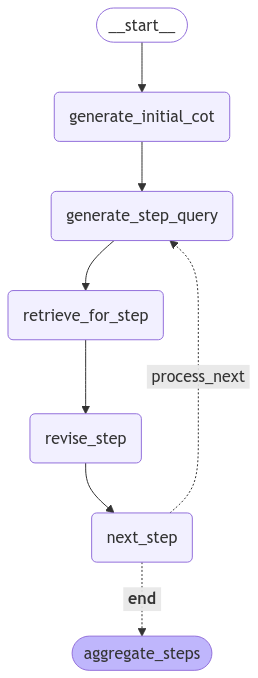

In [ ]:
# === RATRAG WORKFLOW VISUALIZATION ===
# Display the workflow graph structure for better understanding
# This shows the flow of evidence-backed reasoning process

from IPython.display import Image, display

print("Generating RatRAG workflow visualization...")

try:
    # Generate and display the workflow diagram
    # This shows the complete flow from initial reasoning to final synthesis
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    print("Workflow diagram displayed above")
except Exception as e:
    # Visualization requires additional dependencies
    print("Workflow visualization not available (requires extra dependencies)")
    print("Workflow structure: Initial CoT → Query → Retrieval → Revision → Next Step → Aggregation")

In [ ]:
# === RATRAG EXECUTION FUNCTION ===
# Convenient wrapper to execute the complete RatRAG workflow
# This function handles state initialization and result presentation

def run_full_rat(query: str):
    """
    Execute the complete RatRAG workflow for a given query
    
    This function:
    1. Initializes the workflow state
    2. Executes the complete evidence-backed reasoning process  
    3. Displays the final answer and reasoning trace
    
    Args:
        query: User question to process through RatRAG
    """
    print(f"Starting RatRAG analysis for: '{query}'")
    print("=" * 60)
    
    # Initialize the workflow state
    initial_state: RATState = {
        "query":         query,
        "full_cot":      "",           # Will contain initial reasoning
        "thought_steps": [],           # Will contain step-by-step breakdown
        "revised_steps": [],           # Will contain evidence-revised steps
        "final_answer":  "",           # Will contain final synthesized answer
        "current_step":  0,            # Start at first step
        "max_iterations": 10,          # Prevent infinite loops
    }
    
    # Execute the complete workflow
    final_state = graph.invoke(initial_state)
    
    # Display results
    print("\nFINAL ANSWER:")
    print("=" * 40)
    print(final_state["final_answer"])
    
    print("\nEVIDENCE-REVISED REASONING STEPS:")
    print("=" * 40)
    for idx, step in enumerate(final_state["revised_steps"]):
        print(f"Step {idx+1}: {step}")
    
    # Optional: show original thought steps for comparison
    print("\nOriginal thought steps for reference:")
    for i, step in enumerate(final_state["thought_steps"]):
        print(f"{i+1}. {step[:100]}...")  # Truncated for readability

In [ ]:
# === TEST CASE 1: WAITLIST QUERY ===
# Test RatRAG with a specific student query about waitlist status
# This demonstrates how the system handles queries requiring specific information

print("Testing RatRAG with waitlist query...")
run_full_rat(query="What number am I on the waitlist?")

Final Answer:
Sorry, I don't know the answer. Please check the website at https://admissions.ucsc.edu/contact-us#contact-information for more details.

Revised Thought Steps:
Step 1: 1. Waitlisted students at UCSC are advised to accept any offer of admission they receive, as being on the waitlist does not guarantee admission.
Step 2: 2. It is important to check your UC Santa Cruz my.ucsc.edu online account frequently for updates on your waitlist status and to opt in to the waitlist if you receive an invitation. Remember that being on the waitlist does not guarantee admission, so it is advised to accept any other offers of admission you may receive.
['1. Admissions process and waitlist information\n[QUERY] "UCSC admissions process and waitlist information" site:ucsc.edu\n[RETRIEVED] We are advising waitlisted students to take an offer of admission if they receive it. Being on the waitlist at UCSC -- or any of the UCs -- does not guarantee admission.\nthree\nDecember\nEstablish a UC Sant

In [ ]:
# === TEST CASE 2: CLASS SIZE QUERY ===
# Test RatRAG with a complex query requiring multi-step reasoning
# This demonstrates the system's ability to break down complex questions

print("Testing RatRAG with complex class size query...")
run_full_rat(query="What are the class sizes for the lower and upper division classes under the engineering school?")

Final Answer:
Final Answer: Class sizes for lower division engineering courses at UC Santa Cruz vary, with most classes having fewer than 40 students and larger introductory classes ranging from 15-400 students. As students progress to senior standing, they are likely to experience an increasing proportion of small classes.

For more detailed information on class sizes for specific courses, you can refer to the UCSC General Catalog and Schedule of Classes:
- UCSC General Catalog: https://catalog.ucsc.edu/
- Schedule of Classes: https://registrar.ucsc.edu/soc/

Revised Thought Steps:
Step 1: 1. Class sizes at UC Santa Cruz vary depending on the course, with most classes having fewer than 40 students. Larger introductory classes may have anywhere from 15-400 students, while upper-division classes tend to be smaller. The Instructional Activity Dashboard provided by IRAPS offers detailed information on class sizes for different academic divisions and departments, excluding summer quarters.

In [ ]:
# Inspect the source documents retrieved for the first reasoning step
# This helps understand what evidence was used for the initial step
print("Documents retrieved for first reasoning step:")
sourceDocs[0]

['To determine the class sizes for lower and upper division classes under the engineering school at UC Santa Cruz, you can refer to the Instructional Activity Dashboard provided by the Institutional Research, Analytics, and Planning Support (IRAPS). This dashboard provides detailed information on class sizes, including cross-listed classes, for different academic divisions and departments. Note that summer quarters are excluded from these calculations. You can access the dashboard for more detailed and specific data on class sizes on this website: https://iraps.ucsc.edu/iraps-public-dashboards/instructional-activity/class-sizes.html',
 'A student’s class level plays a large part in how many small classes are available. Introductory classes tend to be large, although they are usually accompanied by required small sections or laboratories. Many small classes have prerequisite courses that enroll large numbers of students. Also, certain large classes fulfill campuswide general education r

In [87]:
import os
from typing import List, TypedDict
import operator

# Global list to store retrieved documents per thought step.
sourceDocs = []  # Each element will be a list of strings (documents for that step).

# Import LangGraph components
from langgraph.graph import StateGraph, START, END

# Import LangChain's ChatOpenAI and message types
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, AIMessage, SystemMessage

# Define our state schema for a per-step RAT workflow.
class RATState(TypedDict):
    query: str             # User query
    full_cot: str          # Full chain-of-thought generated initially
    thought_steps: List[str]      # Discrete thought steps (as produced by the LLM)
    revised_steps: List[str]      # Revised versions of each thought step (after retrieval and revision)
    final_answer: str      # Aggregated final answer
    current_step: int      # Index of the thought step being processed
    max_iterations: int    # Maximum number of iterations allowed

# Helper: Split the full chain-of-thought into discrete steps.
def split_cot(full_text: str) -> List[str]:
    steps = [step.strip() for step in full_text.split("\n") if step.strip()]
    return steps

# Node 1: Generate initial chain-of-thought for the query.
def generate_initial_cot(state: RATState) -> RATState:
    llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
    prompt = (
        f"{state['query']}\n\n"
        "You have access to multiple passages about UCSC, including topics such as admissions, class sizes, academic activities, and general course information. "
        "Please think through what pieces of information would be necessary to answer the query effectively. "
        "Provide your chain of thought as a numbered list, with each step on a new line. "
        "For each step, mention the topic or type of information you believe is needed (for example, 'Admissions requirements', 'Class size data', etc.). "
        "Do not include any extra commentary—only output the numbered steps."
    )
    ai_msg = llm.invoke([HumanMessage(content=prompt)])
    state["full_cot"] = ai_msg.content
    state["thought_steps"] = split_cot(ai_msg.content)
    state["current_step"] = 0
    state["revised_steps"] = []
    return state

# Node 2: For the current thought step, generate a retrieval query.
def generate_step_query(state: RATState) -> RATState:
    llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
    current = state["thought_steps"][state["current_step"]]
    prompt = (
        f"Given the following thought step:\n\n'{current}'\n\n"
        "Please provide a concise, single-line retrieval query that could help find supporting evidence from UCSC-related passages and documents. "
        "Output only the query."
    )
    ai_msg = llm.invoke([HumanMessage(content=prompt)])
    state["thought_steps"][state["current_step"]] = current + "\n[QUERY] " + ai_msg.content.strip()
    return state

# Node 3: Retrieve external evidence for the current step using a FAISS vector retriever.
def get_retriever():
    import pandas as pd
    from langchain.document_loaders import DataFrameLoader  
    from langchain.text_splitter import CharacterTextSplitter
    from langchain.embeddings import HuggingFaceEmbeddings
    from langchain.vectorstores import FAISS

    ucsc_passage_df = pd.read_csv("passage.csv")
    ucsc_passage_data_loader = DataFrameLoader(ucsc_passage_df, page_content_column="passage")
    ucsc_passage_data = ucsc_passage_data_loader.load()
    text_splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=50)
    docs = text_splitter.split_documents(ucsc_passage_data)
    embeddings = HuggingFaceEmbeddings()
    db = FAISS.from_documents(docs, embeddings)
    return db.as_retriever()

def retrieve_for_step(state: RATState) -> RATState:
    current = state["thought_steps"][state["current_step"]]
    if "[QUERY]" in current:
        query_part = current.split("[QUERY]", 1)[1].strip()
    else:
        query_part = current 
    docs = retriever.invoke(query_part)  # Expecting a list of Document objects.
    # Save each document's content in sourceDocs.
    sourceDocs.append([doc.page_content for doc in docs])
    retrieved_text = "\n".join([doc.page_content for doc in docs])
    updated_step = current + "\n[RETRIEVED] " + retrieved_text
    state["thought_steps"][state["current_step"]] = updated_step
    return state

# Node 4: Revise the current thought step using the retrieved evidence.
def revise_step(state: RATState) -> RATState:
    llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
    current = state["thought_steps"][state["current_step"]]
    prompt = (
        f"Below is a thought step along with its retrieved evidence:\n\n{current}\n\n"
        "Please revise this thought step to incorporate the evidence and output only the revised thought step."
    )
    ai_msg = llm.invoke([HumanMessage(content=prompt)])
    state["revised_steps"].append(ai_msg.content.strip())
    return state

# Node 5: Move to the next thought step.
def next_step(state: RATState) -> RATState:
    state["current_step"] += 1
    return state

# Node 6: Aggregate all revised thought steps into a final answer.
def aggregate_steps(state: RATState) -> RATState:
    llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
    aggregated = "\n".join(state["revised_steps"])
    prompt = (
        f"User Query: {state['query']}\n\n"
        f"Revised Thought Steps:\n\n{aggregated}\n\n"
        "Based on the above, generate a final answer that addresses the user's query. "
        "If the revised thought steps provide a clear and complete answer, output that final answer along with the relevant details."
        "If they provide only partial information, start your response with 'Sorry, I couldn't find an exact answer, but here is what I found:' followed by a summary of the available information. "
        "If the revised thought steps are not relevant to the query, output: 'Sorry, I don't know the answer. Please check the website at https://admissions.ucsc.edu/contact-us#contact-information for more details.' "
        "Output only the final answer. Also, include links to the relevant UCSC pages if applicable."
    )
    ai_msg = llm.invoke([HumanMessage(content=prompt)])
    state["final_answer"] = ai_msg.content.strip()
    return state

# Conditional function to check if there are more thought steps to process.
def more_steps(state: RATState) -> str:
    total_steps = len(state["thought_steps"])
    effective_max = min(total_steps - 1, state["max_iterations"])
    if state["current_step"] < effective_max:
        return "process_next"
    else:
        return END



In [88]:

# Build the LangGraph.
graph_builder = StateGraph(RATState)
graph_builder.add_node("generate_initial_cot", generate_initial_cot)
graph_builder.add_node("generate_step_query", generate_step_query)
graph_builder.add_node("retrieve_for_step", retrieve_for_step)
graph_builder.add_node("revise_step", revise_step)
graph_builder.add_node("next_step", next_step)
graph_builder.add_node("aggregate_steps", aggregate_steps)

# Define the edges:
graph_builder.add_edge(START, "generate_initial_cot")
graph_builder.add_edge("generate_initial_cot", "generate_step_query")
graph_builder.add_edge("generate_step_query", "retrieve_for_step")
graph_builder.add_edge("retrieve_for_step", "revise_step")
graph_builder.add_edge("revise_step", "next_step")
graph_builder.add_conditional_edges("next_step", more_steps, {"process_next": "generate_step_query", END: "aggregate_steps"})

# Compile the graph.
graph = graph_builder.compile()


In [132]:
sourceDocs.clear()
# Function to run the full RAT workflow.
def run_full_rat(query: str):
    initial_state: RATState = {
        "query": query,
        "full_cot": "",
        "thought_steps": [],
        "revised_steps": [],
        "final_answer": "",
        "current_step": 0,
        "max_iterations": 10,
    }
    final_state = graph.invoke(initial_state)
    print("Final Answer:")
    print(final_state["final_answer"])
    print("\nRevised Thought Steps:")
    for idx, step in enumerate(final_state["revised_steps"]):
        print(f"Step {idx+1}: {step}")
    print("\nFetched Documents (per thought step):")
    for idx, docs in enumerate(sourceDocs):
        print(f"Documents for thought step {idx+1}:")
        for doc in docs:
            print(doc)
        print("\n")
# run_full_rat( "What are the class sizes for the lower and upper division classes under the engineering school?")
run_full_rat("Who can be a member of the Boating Club?")

Final Answer:
Final Answer: Any UCSC student can become a member of the Boating Club by joining the organization through the registered student organizations process. For more information on how to join the Boating Club, students can visit the UCSC Student Organization Advising & Resources (SOAR) website at https://studentorganizations.ucsc.edu/.

Revised Thought Steps:
Step 1: There are about 200 registered student organizations at UCSC, which play a vital role in the campus community and allow students to fully engage in their college experience.

Fetched Documents (per thought step):
Documents for thought step 1:
SOMeCA is home to about 200 registered student organizations! These organizations are vital to the campus climate and community at the University of California, Santa Cruz for students to truly engage in their college experience.
UCSC Administrative and Academic Structure
UCSC Student Membership: $45

Non-Student Quarterly Membership:  $150

Non-Student Annual Membership:  

In [133]:
sourceDocs

[['SOMeCA is home to about 200 registered student organizations! These organizations are vital to the campus climate and community at the University of California, Santa Cruz for students to truly engage in their college experience.',
  'UCSC Administrative and Academic Structure',
  'UCSC Student Membership: $45\n\nNon-Student Quarterly Membership:  $150\n\nNon-Student Annual Membership:  $500\n\nFamily Discount: 1st member full price, additional member half price',
  'Club Membership Fees:\n\nUCSC Student Membership: $45\n\nNon-Student Quarterly Membership:  $150\n\nNon-Student Annual Membership:  $500']]

In [55]:
import pandas as pd
ucsc_qa_df = pd.read_csv("new_qa.csv", index_col=0)

In [57]:
def get_final_answer(query: str) -> str:
    initial_state: RATState = {
        "query": query,
        "full_cot": "",
        "thought_steps": [],
        "revised_steps": [],
        "final_answer": "",
        "current_step": 0,
        "max_iterations": 10,
    }
    final_state = graph.invoke(initial_state)
    return final_state

In [116]:
type(sourceDocs[0][0])

str

In [160]:
agentic_rag_answers = []
count = 0
finalSourceDocs = []
for question in ucsc_qa_df['questions']:
    sourceDocs.clear()
    print(f"Processing question: {question}")
    count += 1
    print(f"Question count: {count}")
    answer = get_final_answer(question)
    agentic_rag_answers.append(answer["final_answer"])
    # source Doc -- List of List of List of String 
    # print(sourceDocs)
    finalSourceDocs.append([
        "".join(inner_list) for inner_list in sourceDocs
    ])
    print(f"Final Answer: {answer['final_answer']}")
    


Processing question: Who can be a member of the Boating Club?
Question count: 1
Final Answer: Final Answer: Any UCSC student can become a member of the Boating Club by joining the organization through the registered student organizations portal on the campus website.

For more information on student organizations at UCSC, you can visit: https://studentorganizations.ucsc.edu/
Processing question: What classes does the boating center offer to community members?
Question count: 2
Final Answer: The UC Santa Cruz Community Boating Center offers classes in sailing, rowing, and kayaking for community members. For more information on class descriptions and schedules, please visit the UCSC Community Boating Center website at https://recreation.ucsc.edu/programs/boating-center/index.html.
Processing question: When is the boating club open?
Question count: 3
Final Answer: Final Answer: The Boating Club at UC Santa Cruz is open on weekends for community members, students, faculty, and staff to enj

In [164]:
src_ans_list = ucsc_qa_df['answers'].tolist()
src_question_list = ucsc_qa_df['questions'].tolist()

In [165]:
len(agentic_rag_answers) , len(finalSourceDocs), len(src_ans_list), len(src_question_list)

(112, 112, 112, 112)

In [168]:
type(finalSourceDocs[1])

list

In [82]:
type(finalSourceDocs[0])

list

In [169]:
import os
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)


# Define the questions, ground truth answers, generated answers, and retrieved contexts
questions = src_question_list
ground_truth_answers = src_ans_list
generated_answers = agentic_rag_answers
retrieved_contexts = finalSourceDocs #[docs.split("\n\n") for docs in searched_docs]


# Create a dataset compatible with Ragas
data = {
    "question": questions,
    "ground_truth": ground_truth_answers,
    "answer": generated_answers,
    "retrieved_contexts": retrieved_contexts,
}
dataset = Dataset.from_dict(data)

metrics = [faithfulness, answer_relevancy, context_recall, context_precision]

results = evaluate(dataset, metrics=metrics, raise_exceptions=False)


results_df = results.to_pandas()

# Display the evaluation results
print(results_df)


Evaluating: 100%|██████████| 448/448 [02:32<00:00,  2.93it/s]


                                            user_input  \
0             Who can be a member of the Boating Club?   
1    What classes does the boating center offer to ...   
2                       When is the boating club open?   
3                 What boats are available to members?   
4             How much does a boating membership cost?   
..                                                 ...   
107  What if I don't fulfill the general education ...   
108                                    What is UC TAP?   
109              When are acceptance notices sent out?   
110  What are the Cross-Campus and Simultaneous Enr...   
111    Can I talk to an adviser during a campus visit?   

                                    retrieved_contexts  \
0    [SOMeCA is home to about 200 registered studen...   
1    [UC Santa Cruz Community Boating Center is a c...   
2    [The boating club exists to give community mem...   
3    [Our boats:\nSailing vessels for weekend use c...   
4    [UCSC St

In [170]:
average_scores = results_df[['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']].mean()

# Display the average scores
print("Average Scores:")
print(average_scores)

Average Scores:
faithfulness         0.627403
answer_relevancy     0.777176
context_recall       0.419271
context_precision    0.642411
dtype: float64
